**Telco Churn – Gün 3: Görselleştirme & Korelasyon**

In [ ]:

# KURULUM & VERİYİ YÜKLE
import os, pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("ggplot")
sns.set_palette("pastel")

IMG_DIR = Path("/content/images")
IMG_DIR.mkdir(parents=True, exist_ok=True)

CSV_CLEAN = Path("/content/cleaned_telco_churn.csv")
CSV_RAW   = Path("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

from google.colab import files
files.upload()


Saving cleaned_telco_churn.csv to cleaned_telco_churn.csv


{'cleaned_telco_churn.csv': b'SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check\n0,1,29.85,29.85,0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False\n0,34,56.95,1889.5,0,True,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,F

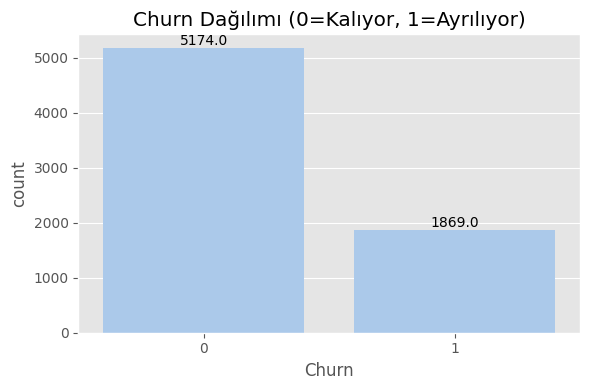

📉 Churn Oranı: %26.54


In [ ]:

# 1) TEMEL DAĞILIMLAR
df = pd.read_csv("cleaned_telco_churn.csv")
df.head()

fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Churn", data=df, ax=ax)
ax.set_title("Churn Dağılımı (0=Kalıyor, 1=Ayrılıyor)")
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+p.get_width()/2, p.get_height()+5),
                ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig(IMG_DIR/"01_churn_distribution.png", dpi=180)
plt.show()

# Churn oranı
rate = df["Churn"].mean()*100
print(f"📉 Churn Oranı: %{rate:.2f}")


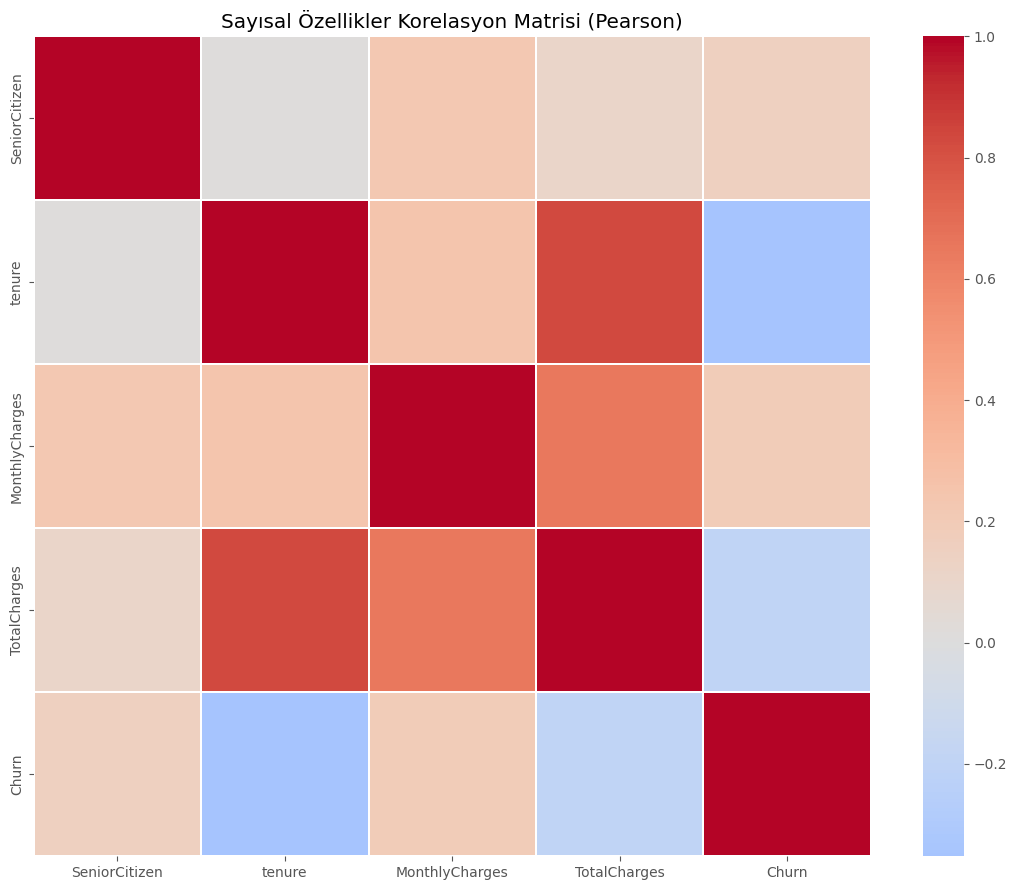

🔎 Churn ile en ilişkili (sayısal) ilk 10 özellik:

tenure            0.352229
TotalCharges      0.198324
MonthlyCharges    0.193356
SeniorCitizen     0.150889
Name: Churn, dtype: float64


In [ ]:

# 2) SAYISAL ÖZELLİKLERİN KORELASYONU (PEARSON)

num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()

plt.figure(figsize=(11,9))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.2)
plt.title("Sayısal Özellikler Korelasyon Matrisi (Pearson)")
plt.tight_layout()
plt.savefig(IMG_DIR/"02_corr_matrix_numeric.png", dpi=180)
plt.show()

# Churn ile en ilişkili sayısal özellikler (mutlak değere göre)
churn_corr = corr["Churn"].drop("Churn").abs().sort_values(ascending=False).head(10)
print("🔎 Churn ile en ilişkili (sayısal) ilk 10 özellik:\n")
print(churn_corr)


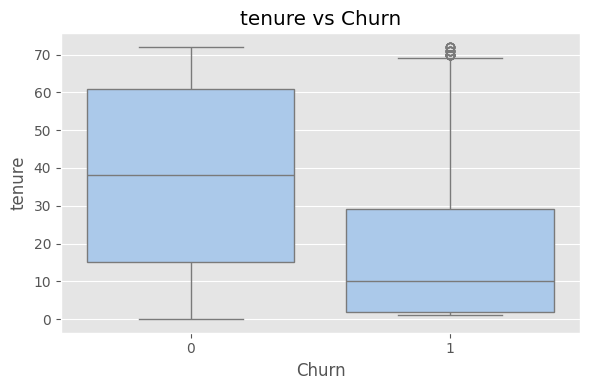

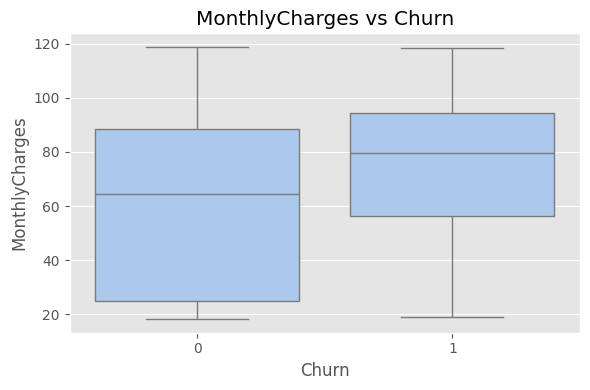

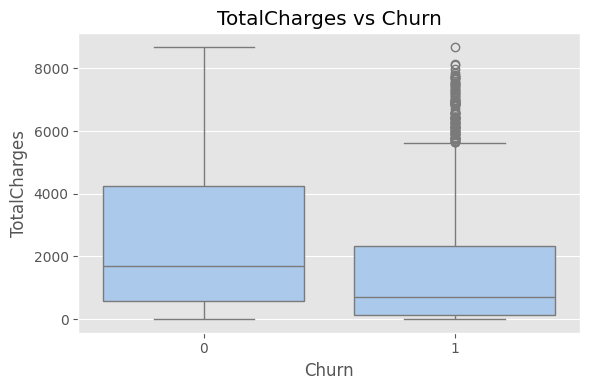

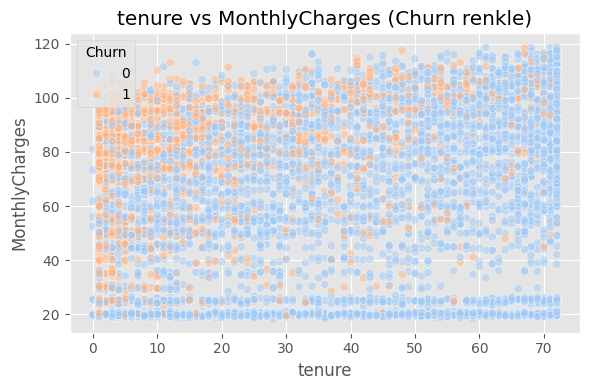

In [ ]:
# =========================================================
# 3) NUMERIK vs CHURN: KUTU GRAFİKLERİ & DAĞILIM
# =========================================================
focus_numeric = [c for c in ["tenure","MonthlyCharges","TotalCharges"] if c in df.columns]
for col in focus_numeric:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.tight_layout()
    plt.savefig(IMG_DIR/f"03_box_{col}_vs_churn.png", dpi=180)
    plt.show()

# Dağılım (tenure vs MonthlyCharges) – Churn rengine göre
if all(c in df.columns for c in ["tenure","MonthlyCharges"]):
    plt.figure(figsize=(6,4))
    sns.scatterplot(x="tenure", y="MonthlyCharges", hue="Churn", data=df, alpha=0.5)
    plt.title("tenure vs MonthlyCharges (Churn renkle)")
    plt.tight_layout()
    plt.savefig(IMG_DIR/"04_scatter_tenure_monthly_churn.png", dpi=180)
    plt.show()


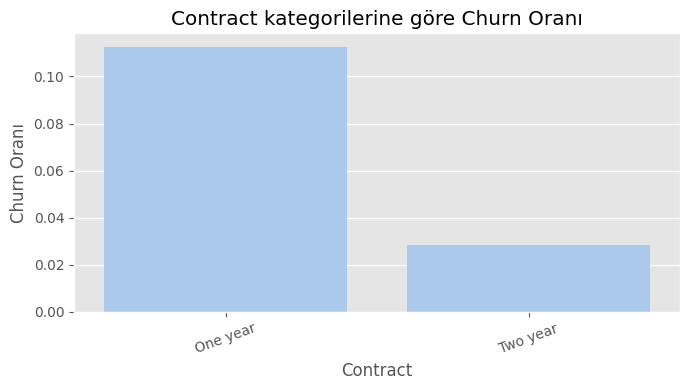


📊 Contract – Churn Oranları:
    Contract  churn_rate
0  One year       11.27
1  Two year        2.83


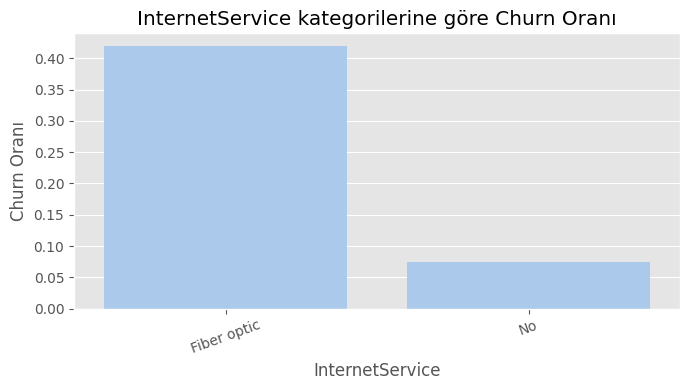


📊 InternetService – Churn Oranları:
   InternetService  churn_rate
0     Fiber optic       41.89
1              No        7.40


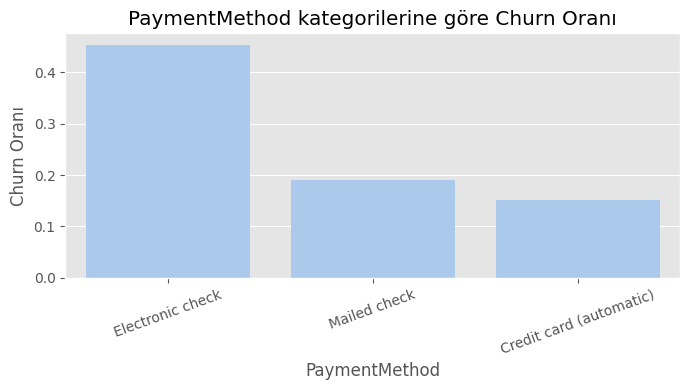


📊 PaymentMethod – Churn Oranları:
              PaymentMethod  churn_rate
1         Electronic check       45.29
2             Mailed check       19.11
0  Credit card (automatic)       15.24


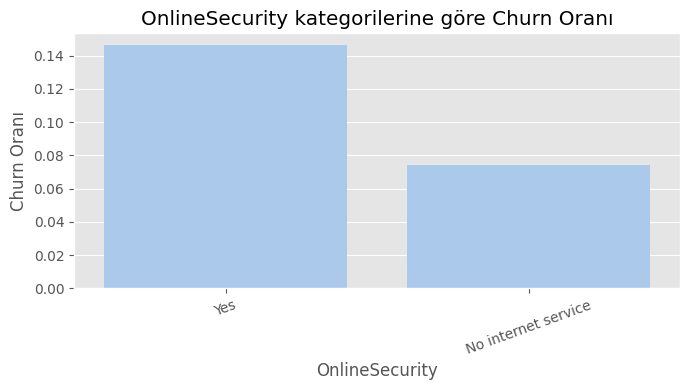


📊 OnlineSecurity – Churn Oranları:
         OnlineSecurity  churn_rate
1                  Yes       14.61
0  No internet service        7.40


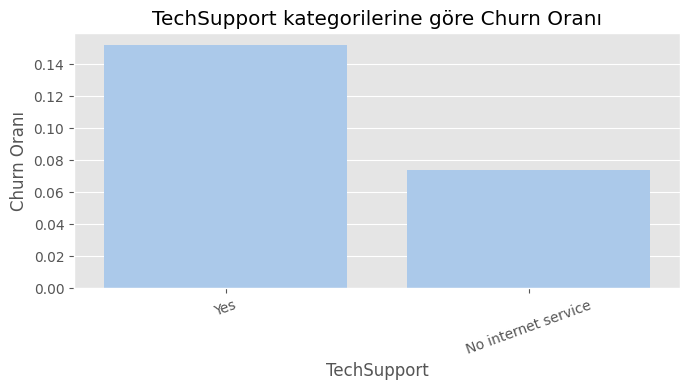


📊 TechSupport – Churn Oranları:
            TechSupport  churn_rate
1                  Yes       15.17
0  No internet service        7.40


In [ ]:
# =========================================================
# 4) KATEGORİK vs CHURN: ORAN KARŞILAŞTIRMALARI
#    (One-hot sonrası kolon isimleri: col_value şeklinde)
#    Örn: Contract_Two year, InternetService_Fiber optic ...
# =========================================================
def churn_rate_for(prefix):
    """one-hot kolonu prefix ile başlayan kategoriler için churn oranı tablo/plot"""
    cols = [c for c in df.columns if c.startswith(prefix+"_")]
    if not cols:
        print(f"⚠️ '{prefix}' için one-hot kolon bulunamadı (prefix yanlış olabilir).")
        return None
    # kategori adlarını çıkar (prefix sonrası)
    rates = []
    for c in cols:
        mask = df[c]==1
        if mask.sum() > 0:
            rates.append((c.replace(prefix+"_",""), df.loc[mask, "Churn"].mean()))
    out = pd.DataFrame(rates, columns=[prefix, "churn_rate"]).sort_values("churn_rate", ascending=False)
    plt.figure(figsize=(7,4))
    sns.barplot(x=prefix, y="churn_rate", data=out)
    plt.xticks(rotation=20)
    plt.ylabel("Churn Oranı")
    plt.title(f"{prefix} kategorilerine göre Churn Oranı")
    plt.tight_layout()
    plt.savefig(IMG_DIR/f"05_churn_by_{prefix}.png", dpi=180)
    plt.show()
    return out

tables = {}
for prefix in ["Contract","InternetService","PaymentMethod","OnlineSecurity","TechSupport"]:
    t = churn_rate_for(prefix)
    if t is not None:
        print(f"\n📊 {prefix} – Churn Oranları:\n", (t.assign(churn_rate=lambda s: (s["churn_rate"]*100).round(2))))
        tables[prefix] = t


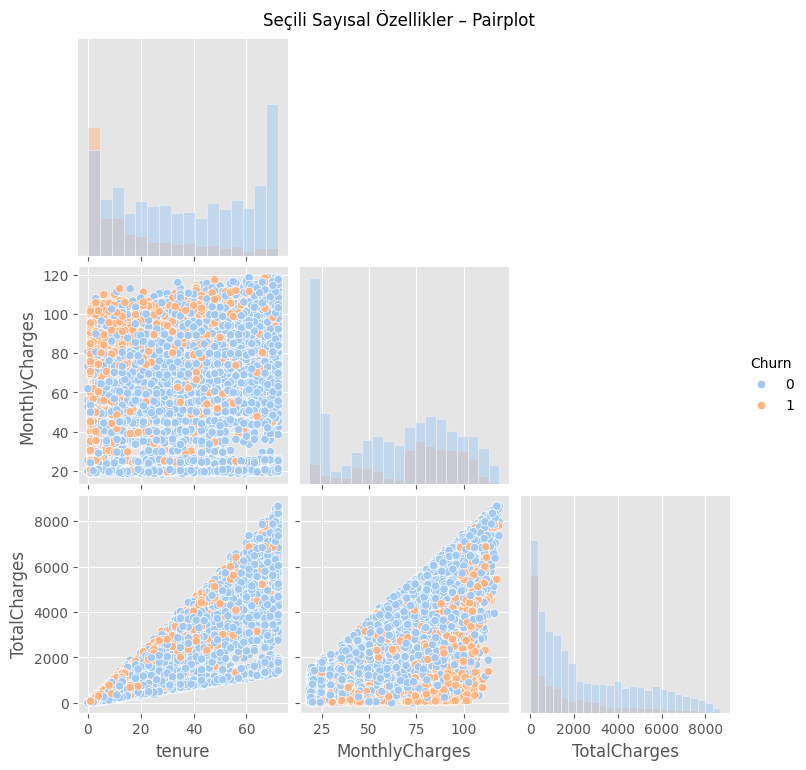

In [ ]:
# =========================================================
# 5) PAIRPLOT (SEÇİLİ SAYISAL ÖZELLİKLER)
# =========================================================
sel = [c for c in ["tenure","MonthlyCharges","TotalCharges","Churn"] if c in df.columns]
sns.pairplot(df[sel], hue="Churn", diag_kind="hist", corner=True)
plt.suptitle("Seçili Sayısal Özellikler – Pairplot", y=1.02)
plt.savefig(IMG_DIR/"06_pairplot_numeric_selected.png", dpi=180)
plt.show()


In [ ]:

# 6) NUMERIK vs CHURN: POINT–BISERIAL KORELASYON
#    (binary hedef ile sayısal özellik ilişkisi)

try:
    from scipy.stats import pointbiserialr
    results = []
    for col in num_cols:
        if col == "Churn":
            continue
        r, p = pointbiserialr(df["Churn"], df[col])
        results.append((col, r, p))
    pb = pd.DataFrame(results, columns=["feature","r_pointbiserial","p_value"])\
           .sort_values("r_pointbiserial", key=lambda s: s.abs(), ascending=False)
    display(pb.head(12))
    pb.to_csv(IMG_DIR/"07_pointbiserial_top.csv", index=False)
    print("✅ point-biserial tablo kaydedildi:", IMG_DIR/"07_pointbiserial_top.csv")
except Exception as e:
    print("⚠️ SciPy bulunamadı veya bir hata oluştu:", e)


,feature,r_pointbiserial,p_value
1,tenure,-0.352229,7.999058e-205
3,TotalCharges,-0.198324,2.127212e-63
2,MonthlyCharges,0.193356,2.706646e-60
0,SeniorCitizen,0.150889,3.839860e-37


✅ point-biserial tablo kaydedildi: /content/images/07_pointbiserial_top.csv


In [ ]:

# 7) MEDIUM İÇİN ÖZET METRİKLERİ YAZDIR

summary_lines = []

summary_lines.append(f"Churn Oranı: %{df['Churn'].mean()*100:.2f}")
if "MonthlyCharges" in df.columns:
    m_yes  = df.loc[df["Churn"]==1, "MonthlyCharges"].mean()
    m_no   = df.loc[df["Churn"]==0, "MonthlyCharges"].mean()
    summary_lines.append(f"Avg MonthlyCharges (Churn=1): {m_yes:.2f} | (Churn=0): {m_no:.2f}")

if "tenure" in df.columns:
    t_yes  = df.loc[df["Churn"]==1, "tenure"].median()
    t_no   = df.loc[df["Churn"]==0, "tenure"].median()
    summary_lines.append(f"Median Tenure (Churn=1): {t_yes:.0f} ay | (Churn=0): {t_no:.0f} ay")

print("\n".join(["📝 Medium için özet:", *summary_lines]))
print(f"\n🖼️ Kaydedilen görseller: {len(list(IMG_DIR.glob('*.png')))} adet.  Klasör: {IMG_DIR}")


📝 Medium için özet:
Churn Oranı: %26.54
Avg MonthlyCharges (Churn=1): 74.44 | (Churn=0): 61.27
Median Tenure (Churn=1): 10 ay | (Churn=0): 38 ay

🖼️ Kaydedilen görseller: 12 adet.  Klasör: /content/images
